In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

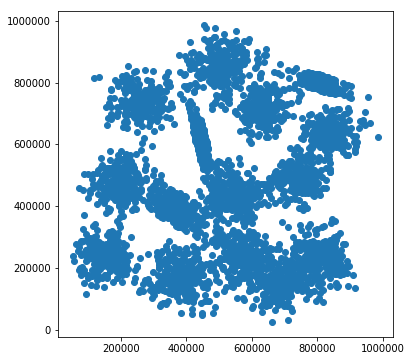

In [2]:
import sys
sys.path = ["/Users/jklinger/Nesta/jklearn/"] + sys.path

from matplotlib import pyplot as plt
import sklearn.cluster
import sklearn.datasets
import hdbscan
import fastcluster
import time
from jklearn.cluster import Omnislash
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import os

data = []
r = requests.get("http://cs.joensuu.fi/sipu/datasets/s2.txt")
for line in r.text.split("\n"):
    if line.strip() == "":
        continue
    x, y = line.strip().split()
    data.append({"x":float(x), "y":float(y)})
df = pd.DataFrame(data)
data = df.as_matrix()

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df.x, df.y)

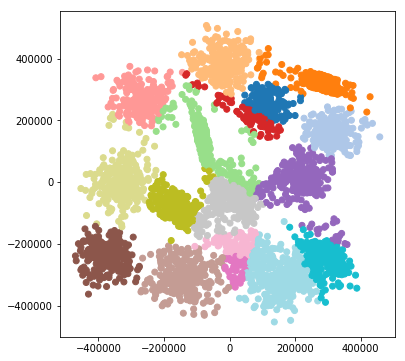

In [18]:
omni = Omnislash(50, evr_max=0.75, sample_space_size=1000, tight_data=True)
labels = omni.fit_predict(data)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df.x, df.y, c=labels, cmap="tab20")

# Benchmark 1 million data points against numbers of features

In [10]:
def benchmark_algorithm(label, cluster_function, dataset_dimensions, dataset_sizes, 
                        clusters, max_time, s):

    print(label)
    for idat, n in enumerate(dataset_sizes):
        print("\t", n, f"({idat+1}/{len(dataset_sizes)})")
        do_break = False
        for idim, dim in enumerate(dataset_dimensions):        
            print("\t\t", dim, f"({idim+1}/{len(dataset_dimensions)})")
            # Use sklearns make_blobs to generate a random dataset with specified size
            # dimension and number of clusters
            time_taken = 0
            data, labels = sklearn.datasets.make_blobs(n_samples=n,
                                                       n_features=dim,
                                                       centers=clusters)
            del labels

            filename = (f"outputs/{label}_dim-{dim}_n-{n}"
                        f"_centres-{clusters}_run-{s}.out")

            if filename.lstrip("outputs/") in os.listdir("outputs/"):
                print("\t\tAlready done")
                continue                

            with open(filename, "w") as f:
                pass

            start_time = time.time()
            cluster_function(data)
            time_taken = time.time() - start_time
            with open(filename, "a") as f:
                f.write(str(time_taken))
                print(f"\t\t{time_taken}")

            del data            
            #del labels
            # If we are taking more than max_time then abort -- we don't
            # want to spend excessive time on slow algorithms
            if time_taken > max_time:
                break


In [ ]:
dataset_sizes = [int(1e6)]
#dataset_dimensions = np.array([int(x) for x in np.logspace(start=2, stop=3, num=5, base=10)])
dataset_dimensions = [100, 177, 316, 400]
clusters = 100
max_time = 1000
sample_size = 2

algs = {"Omnislash": (Omnislash, (5000,), {"evr_max":0.75}),
        "sklearn Kmeans": (sklearn.cluster.KMeans, (clusters,), {}),
        "sklearn DBSCAN": (sklearn.cluster.DBSCAN, (), {"eps":1.25}),
        "fastcluster": (fastcluster, (), {}), 
        "HDBSCAN": (hdbscan.HDBSCAN, (), {})}

for label, (clusterer, args, kwargs) in algs.items():
    for s in range(sample_size):
        cluster_instance = clusterer(*args, **kwargs)
        if label != "fastcluster":
            cluster_function = cluster_instance.fit
        else:
            cluster_function = cluster_instance.linkage_vector
        benchmark_algorithm(label, cluster_function, dataset_dimensions, dataset_sizes,
                            clusters, max_time, s)
        del cluster_instance


Omnislash
	 1000000 (1/1)
		 100 (1/5)
		Already done
		 177 (2/5)
		Already done
		 316 (3/5)
		Already done
		 562 (4/5)
fitting


In [ ]:

# sns.regplot(x='x', y='y', data=omni_data, order=2,
#              label='Omnislash', x_estimator=np.mean)

# sns.regplot(x='x', y='y', data=k_means_data_dim, order=2,
#             label='Sklearn K-Means', x_estimator=np.mean)

# sns.regplot(x='x', y='y', data=dbscan_data_dim, order=2,
#             label='Sklearn DBSCAN', x_estimator=np.mean)

# sns.regplot(x='x', y='y', data=hdbscan_data, order=2,
#             label='HDBSCAN', x_estimator=np.mean)

# sns.regplot(x='x', y='y', data=fastclust_data, order=2,
#             label='Fastcluster Single Linkage', x_estimator=np.mean)

# plt.gca().axis([0, 650, 0, 200])
# plt.gca().set_xlabel('Number of data points')
# plt.gca().set_ylabel('Time taken to cluster (s)')
# plt.title('Performance Comparison of Clustering Implementations')
# plt.legend()